# Notebook: Active Learning 📚



In [8]:
import os
from os.path import join
import torch
import pandas as pd
import sys
from torch.utils.data import Dataset,DataLoader
import numpy as np

sys.path.append(join(os.getcwd(),'src'))

from model import LinearNet, train_one_epoch
from typing import List, Dict

PATH_DATA = join(os.getcwd(), 'data')
PATH_MODEL = join(os.getcwd(), 'models')

In [2]:
EPOCHS = 50


# Hate Dataset

## 1 Setup

### 1.1 Load Model

In [3]:
model = LinearNet(384, 100)
model.load_state_dict(torch.load(join(PATH_MODEL,'nn_active_learn_hate.pt')))
model.eval()

LinearNet(
  (embeddings): SentenceTransformer(
    (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
    (2): Normalize()
  )
  (hidden): Linear(in_features=384, out_features=100, bias=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

### 1.2 Load Data

In [4]:
#### Load TRAIN SETS an process
train = pd.read_csv(join(PATH_DATA, 'train_hate.csv'))

first_train_set = pd.read_csv(join(PATH_DATA, 'train_subsample_active_learning.csv'))
idx_non_wanted = first_train_set.loc[:,'Unnamed: 0.1']
train = train.drop(idx_non_wanted.values.tolist())

train = train.loc[train.loc[:,'text']!='',]
train = train.loc[train.loc[:,'text'].notna(),]


#### Load VALIDATION SET

val = pd.read_csv(join(PATH_DATA, 'val_hate.csv'))

### 1.3 Initial State of Model

In [5]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

preds = model.predict(val.text.values.tolist()).detach().numpy()

metrics = {name_metric: metric(val.labels.values, preds) for name_metric, metric in zip(['acc', 'f1', 'precision', 'recall'],
                                                                                        [accuracy_score, f1_score, precision_score, recall_score])}

print('|Model stage|Accuracy|F1|Precision|Recall|')
print('|:---:|:---:|:---:|:---:|:---:|')
print(f"|after first training|{metrics['acc']*100:.02f}|{metrics['f1']*100:.02f}|{metrics['precision']*100:.02f}|{metrics['recall']*100:.02f}|")


|Model stage|Accuracy|F1|Precision|Recall|
|:---:|:---:|:---:|:---:|:---:|
|after first training|66.67|64.62|59.31|70.98|


|Model stage|Accuracy|F1|Precision|Recall|
|:---:|:---:|:---:|:---:|:---:|
|after first training|66.67|64.62|59.31|70.98|

## 1. Retrain on random sets

In [6]:
class TweetDataset(Dataset):
    def __init__(self, texts: List, labels: List):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)
		
    def __getitem__(self, idx):
        texts = self.texts[idx]
        labels = self.labels[idx]
        return texts, torch.tensor(labels, dtype=torch.long)

In [9]:
lr = 1e-4

losses_dict = {}
preds_dict = {}
for seed in np.arange(5):
    model_retrain_random = LinearNet(384, 100)
    model_retrain_random.load_state_dict(torch.load(join(PATH_MODEL,'nn_active_learn_hate.pt')))
    train_undersample = train.sample(100, random_state=seed)
    
    train_loader = DataLoader(TweetDataset(train_undersample.text.values.tolist(), train_undersample.labels.values.tolist()), batch_size=8)
    optimizer = torch.optim.SGD(model_retrain_random.parameters(), lr=lr)

    losses = []

    for epoch in (range(EPOCHS)):
        losses.append(train_one_epoch(model_retrain_random, train_loader, optimizer))

    losses_dict['seed'+str(seed)] = losses
    preds_dict['seed_'+str(seed)] = model_retrain_random.predict(val.text.values.tolist()).detach().numpy()


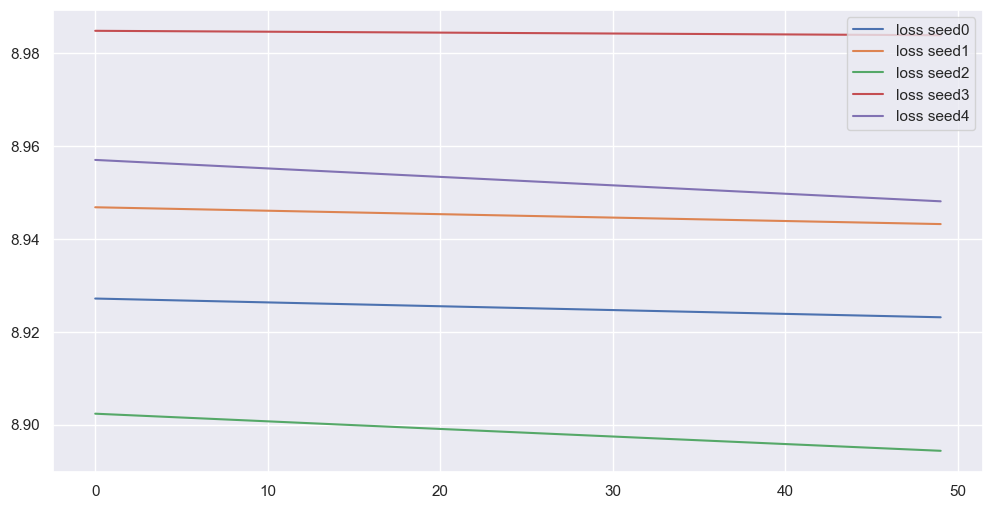

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()

for seed, loss in losses_dict.items():
    ax.plot(np.arange(EPOCHS), loss, label=f'loss {seed}')
    
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score


preds = model_retrain_random.predict(val.text.values.tolist()).detach().numpy()


accuracies = []
f1s = [] 
precisions = []
recalls = []

for k, preds in preds_dict.items():
   accuracies.append(accuracy_score(val.labels.values, preds))
   f1s.append(f1_score(val.labels.values, preds))
   precisions.append(precision_score(val.labels.values, preds))
   recalls.append(recall_score(val.labels.values, preds))


In [13]:
print('|Model stage|Accuracy|F1|Precision|Recall|')
print('|:---:|:---:|:---:|:---:|:---:|')
print(f"|retrain without active learning|{np.mean(accuracies)*100:.02f} + {np.std(accuracies)*100:.02f}|{np.mean(f1s)*100:.02f} + {np.std(f1s)*100:.02f}| \
                                        {np.mean(precisions)*100:.02f} + {np.std(precisions)*100:.02f}|{np.mean(recalls)*100:.02f} + {np.std(recalls)*100:.02f}|")


|Model stage|Accuracy|F1|Precision|Recall|
|:---:|:---:|:---:|:---:|:---:|
|retrain without active learning|66.78 + 0.10|63.68 + 0.59|                                         59.96 + 0.39|67.93 + 1.84|


|Model stage|Accuracy|F1|Precision|Recall|
|:---:|:---:|:---:|:---:|:---:|
|after first training|66.67|64.62|59.31|70.98|
|retrain without active learning|66.78 + 0.10|63.68 + 0.59|                                         59.96 + 0.39|67.93 + 1.84|

## 2. Active learning Strategy

### 2.1 Forecast Data and Calculate the Entropy

In [14]:
import numpy as np
import math

probas = model.forward(train.text.values.tolist()).detach().numpy()

entropy_array = np.empty(probas.shape[0])
for k in range(probas.shape[0]):
    entropy_array[k] = -np.sum(probas[k,]*np.log2(probas[k,]))


In [15]:
train['preds'] = model.predict(train.text.values.tolist()).detach().numpy()
train['entropy'] = entropy_array

### 2.2 Calculate the cosine similarity

In [47]:
def cosine_similarity(embedding1: np.array, embedding2: np.array) -> float:
    "computes cosine similarity"
    return np.dot(embedding1, embedding2)/(np.linalg.norm(embedding1)*np.linalg.norm(embedding2))


def cosine_similarity_text_matrix(embedding1: np.array, matrix_embeddings: np.array):
    similarities = []
    for k in range(matrix_embeddings.shape[0]):
        similarities.append(cosine_similarity(embedding1, matrix_embeddings[k,]))
    return np.mean(similarities)

Calculate the embeddings

In [48]:
from sentence_transformers import SentenceTransformer

model_embeddings = SentenceTransformer('all-MiniLM-L6-v2')

embeddings_reference = model_embeddings.encode(first_train_set.text.values)

embeddings_train = model_embeddings.encode(train.text.values)

In [49]:
avg_similarities = []
for k in range(embeddings_train.shape[0]):
    avg_similarities.append(cosine_similarity_text_matrix(embeddings_train[k], embeddings_reference))

train['similarities'] = avg_similarities

### 2.3 Label the samples with highest Entropy

In [20]:
train_entropy = train.sort_values(by=['entropy'], ascending=False).iloc[:100,]

lr = 1e-4

model_entropy = LinearNet(384, 100)
model_entropy.load_state_dict(torch.load(join(PATH_MODEL,'nn_active_learn_hate.pt')))
    
train_loader = DataLoader(TweetDataset(train_entropy.text.values.tolist(), train_entropy.labels.values.tolist()), batch_size=8)
optimizer = torch.optim.SGD(model_entropy.parameters(), lr=lr)

losses = []

for epoch in (range(EPOCHS)):
    losses.append(train_one_epoch(model_entropy, train_loader, optimizer))

In [22]:
preds = model_entropy.predict(val.text.values.tolist()).detach().numpy()

metrics = {name_metric: metric(val.labels.values, preds) for name_metric, metric in zip(['acc', 'f1', 'precision', 'recall'],
                                                                                        [accuracy_score, f1_score, precision_score, recall_score])}

print('|Model stage|Accuracy|F1|Precision|Recall|')
print('|:---:|:---:|:---:|:---:|:---:|')
print(f"|retrain entropy|{metrics['acc']*100:.02f}|{metrics['f1']*100:.02f}|{metrics['precision']*100:.02f}|{metrics['recall']*100:.02f}|")


|Model stage|Accuracy|F1|Precision|Recall|
|:---:|:---:|:---:|:---:|:---:|
|retrain entropy|66.44|60.26|61.23|59.33|


|Model stage|Accuracy|F1|Precision|Recall|
|:---:|:---:|:---:|:---:|:---:|
|after first training|66.67|64.62|59.31|70.98|
|retrain without active learning|66.78 + 0.10|63.68 + 0.59|                                         59.96 + 0.39|67.93 + 1.84|
|retrain entropy|66.44|60.26|61.23|59.33|

### 2.4 Forecast samples with highest entropy version 2

In [44]:
train_positive_entropy = train.loc[train.loc[:,'preds']==1].sort_values(by=['entropy'], ascending=False).iloc[:50,]
train_negative_entropy = train.loc[train.loc[:,'preds']==0].sort_values(by=['entropy'], ascending=False).iloc[:50,]
train_entropy_v2 = pd.concat((train_positive_entropy,train_negative_entropy)).sample(frac=1, random_state=42)


print(f'there are {np.unique(train_entropy_v2.labels, return_counts=True)[1][0]} negative samples and {np.unique(train_entropy_v2.labels, return_counts=True)[1][1]} positive samples')


## We balance the training set

train_entropy_v2_positive = train_entropy_v2.loc[train_entropy_v2.loc[:,'labels']==0,].sample(train_entropy_v2.loc[train_entropy_v2.loc[:,'labels']==1,].shape[0], random_state=42)
train_entropy_v3 = pd.concat((train_entropy_v2_positive,train_entropy_v2.loc[train_entropy_v2.loc[:,'labels']==1,] )).sample(frac=1, random_state=42)


lr = 1e-3

model_entropy = LinearNet(384, 100)
model_entropy.load_state_dict(torch.load(join(PATH_MODEL,'nn_active_learn_hate.pt')))
    
train_loader = DataLoader(TweetDataset(train_entropy_v3.text.values.tolist(), train_entropy_v3.labels.values.tolist()), batch_size=8)
optimizer = torch.optim.SGD(model_entropy.parameters(), lr=lr)

losses = []

for epoch in (range(EPOCHS)):
    losses.append(train_one_epoch(model_entropy, train_loader, optimizer))

preds = model_entropy.predict(val.text.values.tolist()).detach().numpy()

metrics = {name_metric: metric(val.labels.values, preds) for name_metric, metric in zip(['acc', 'f1', 'precision', 'recall'],
                                                                                        [accuracy_score, f1_score, precision_score, recall_score])}

print('|Model stage|Accuracy|F1|Precision|Recall|')
print('|:---:|:---:|:---:|:---:|:---:|')
print(f"|retrain entropy|{metrics['acc']*100:.02f}|{metrics['f1']*100:.02f}|{metrics['precision']*100:.02f}|{metrics['recall']*100:.02f}|")


there are 77 negative samples and 23 positive samples
|Model stage|Accuracy|F1|Precision|Recall|
|:---:|:---:|:---:|:---:|:---:|
|retrain entropy|66.89|65.19|59.36|72.28|


|Model stage|Accuracy|F1|Precision|Recall|
|:---:|:---:|:---:|:---:|:---:|
|after first training|66.67|64.62|59.31|70.98|
|retrain without active learning|66.78 + 0.10|63.68 + 0.59|                                         59.96 + 0.39|67.93 + 1.84|
|retrain entropy|66.44|60.26|61.23|59.33|
|retrain entropy v2|66.89|65.19|59.36|72.28|

### 2.4 Label Samples less similar

In [55]:
train_similar= train.sort_values(by=['similarities'], ascending=True).iloc[:100,]

lr = 1e-4

model_similar = LinearNet(384, 100)
model_similar.load_state_dict(torch.load(join(PATH_MODEL,'nn_active_learn_hate.pt')))
    
train_loader = DataLoader(TweetDataset(train_similar.text.values.tolist(), train_similar.labels.values.tolist()), batch_size=8)
optimizer = torch.optim.SGD(model_similar.parameters(), lr=lr)

losses = []

for epoch in (range(EPOCHS)):
    losses.append(train_one_epoch(model_similar, train_loader, optimizer))


preds = model_similar.predict(val.text.values.tolist()).detach().numpy()

metrics = {name_metric: metric(val.labels.values, preds) for name_metric, metric in zip(['acc', 'f1', 'precision', 'recall'],
                                                                                        [accuracy_score, f1_score, precision_score, recall_score])}

print('|Model stage|Accuracy|F1|Precision|Recall|')
print('|:---:|:---:|:---:|:---:|:---:|')
print(f"|retrain similarity|{metrics['acc']*100:.02f}|{metrics['f1']*100:.02f}|{metrics['precision']*100:.02f}|{metrics['recall']*100:.02f}|")


|Model stage|Accuracy|F1|Precision|Recall|
|:---:|:---:|:---:|:---:|:---:|
|retrain similarity|67.44|58.08|64.86|52.59|


|Model stage|Accuracy|F1|Precision|Recall|
|:---:|:---:|:---:|:---:|:---:|
|after first training|66.67|64.62|59.31|70.98|
|retrain without active learning|66.78 + 0.10|63.68 + 0.59|                                         59.96 + 0.39|67.93 + 1.84|
|retrain entropy|66.44|60.26|61.23|59.33|
|retrain entropy v2|66.89|65.19|59.36|72.28|
|retrain similarity|67.44|58.08|64.86|52.59|

### Forecast samples less similar version 3

In [58]:
train_positive_similarities = train.loc[train.loc[:,'preds']==1].sort_values(by=['similarities'], ascending=True).iloc[:50,]
train_negative_similarities = train.loc[train.loc[:,'preds']==0].sort_values(by=['similarities'], ascending=True).iloc[:50,]
train_similarities_v2 = pd.concat((train_positive_similarities,train_negative_similarities)).sample(frac=1, random_state=42)


print(f'there are {np.unique(train_similarities_v2.labels, return_counts=True)[1][0]} negative samples and {np.unique(train_similarities_v2.labels, return_counts=True)[1][1]} positive samples')


## We balance the training set
train_similarities_v2_positive = train_similarities_v2.loc[train_similarities_v2.loc[:,'labels']==0,].sample(train_similarities_v2.loc[train_similarities_v2.loc[:,'labels']==1,].shape[0], random_state=42)
train_similarities_v3 = pd.concat((train_similarities_v2_positive,train_similarities_v2.loc[train_similarities_v2.loc[:,'labels']==1,] )).sample(frac=1, random_state=42)

lr = 1e-3

model_similar = LinearNet(384, 100)
model_similar.load_state_dict(torch.load(join(PATH_MODEL,'nn_active_learn_hate.pt')))
    
train_loader = DataLoader(TweetDataset(train_similarities_v3.text.values.tolist(), train_similarities_v3.labels.values.tolist()), batch_size=8)
optimizer = torch.optim.SGD(model_similar.parameters(), lr=lr)

losses = []

for epoch in (range(EPOCHS)):
    losses.append(train_one_epoch(model_similar, train_loader, optimizer))

preds = model_similar.predict(val.text.values.tolist()).detach().numpy()

metrics = {name_metric: metric(val.labels.values, preds) for name_metric, metric in zip(['acc', 'f1', 'precision', 'recall'],
                                                                                        [accuracy_score, f1_score, precision_score, recall_score])}

print('|Model stage|Accuracy|F1|Precision|Recall|')
print('|:---:|:---:|:---:|:---:|:---:|')
print(f"|retrain similarity v2|{metrics['acc']*100:.02f}|{metrics['f1']*100:.02f}|{metrics['precision']*100:.02f}|{metrics['recall']*100:.02f}|")


there are 93 negative samples and 7 positive samples
|Model stage|Accuracy|F1|Precision|Recall|
|:---:|:---:|:---:|:---:|:---:|
|retrain entropy|66.56|64.46|59.22|70.73|


|Model stage|Accuracy|F1|Precision|Recall|
|:---:|:---:|:---:|:---:|:---:|
|after first training|66.67|64.62|59.31|70.98|
|retrain without active learning|66.78 + 0.10|63.68 + 0.59|                                         59.96 + 0.39|67.93 + 1.84|
|retrain entropy|66.44|60.26|61.23|59.33|
|retrain entropy v2|66.89|65.19|59.36|72.28|
|retrain similarity|67.44|58.08|64.86|52.59|
|retrain similarity v2|66.56|64.46|59.22|70.73|

### 3. Mixing both Active Learning Strategies

In [66]:
candidates_entropy = train.sort_values(by=['entropy'], ascending=True).iloc[:200,]
train_entropy_similarity = candidates_entropy.sort_values(by=['similarities'], ascending=True).iloc[:100,]


lr = 1e-3

model_entropy_similarity = LinearNet(384, 100)
model_entropy_similarity.load_state_dict(torch.load(join(PATH_MODEL,'nn_active_learn_hate.pt')))
    
train_loader = DataLoader(TweetDataset(train_entropy_similarity.text.values.tolist(), train_entropy_similarity.labels.values.tolist()), batch_size=8)
optimizer = torch.optim.SGD(model_entropy_similarity.parameters(), lr=lr)

losses = []

for epoch in (range(EPOCHS)):
    losses.append(train_one_epoch(model_entropy_similarity, train_loader, optimizer))

preds = model_entropy_similarity.predict(val.text.values.tolist()).detach().numpy()

metrics = {name_metric: metric(val.labels.values, preds) for name_metric, metric in zip(['acc', 'f1', 'precision', 'recall'],
                                                                                        [accuracy_score, f1_score, precision_score, recall_score])}

print('|Model stage|Accuracy|F1|Precision|Recall|')
print('|:---:|:---:|:---:|:---:|:---:|')
print(f"|retrain similarity v2|{metrics['acc']*100:.02f}|{metrics['f1']*100:.02f}|{metrics['precision']*100:.02f}|{metrics['recall']*100:.02f}|")

(array([0, 1]), array([35, 65]))
